# Written By: Rupesh Kumar Dey

Problem: Fraud Level Estimation for New Loan Applications

Problem Type: Regression

In [2]:
"""
PROBLEM STATEMENT SUMMARY:
- Financial Institutions are constantly working to assess the risk of loan applicants more accurately. 
- Being good at gauging customer loan risk allows better portfolio management by the company
- This project is pertaining to loan issuance and repayment and their associated fraud level given various features. 
- The aim is to develop a model to predict / estimate loan risk / quality for a given loan application. 

DATASET: 
- The dataset are comprised of 3 data tables which house information / features regarding
- 1. loan application
- 2. loan repayment
- 3. loan fraud level (by clearfraudscore)

IMPLEMENTATION:
- This notebook details the Experimentation and implementation of the model development to gauge a loan applications clearfraudscore
- With a given predicted clearfraudscore, the applicant can automatically be flagged by setting a threshold on the fraud score. 
- This will help reduce the burden and process in manually sieving through and processing loan applications and help the company better manage their loan portfolio
- The notebook comprises the end-to-end pipeline for model development consisting of 
- 1) initial data analysis
- 2) feature engineering
- 3) handling missing values
- 4) feature selection
- 5) model development + tuning 
- 6) final proposed solution 

- In the process of developing the solution, several process / steps in the feature engineering phase to derive new features took a very long process to generate.
- To derive some features the proecss would take around 1 days to process. 
- In order to ensure reproducability of the entire script and practicality, these processed features were saved externally in the project folder either as JSON files or in CSV files
- These externally saved files would then be reimported and read into the notebook and used for remaining steps. 
- This step is deemed acceptable as the data generated would remain the same across each run as we're using the same raw dataset each time. 
"""

"\nPROBLEM STATEMENT SUMMARY:\n- Financial Institutions are constantly working to assess the risk of loan applicants more accurately. \n- Being good at gauging customer loan risk allows better portfolio management by the company\n- This project is pertaining to loan issuance and repayment and their associated fraud level given various features. \n- The aim is to develop a model to predict / estimate loan risk / quality for a given loan application. \n\nDATASET: \n- The dataset are comprised of 3 data tables which house information / features regarding\n- 1. loan application\n- 2. loan repayment\n- 3. loan fraud level (by clearfraudscore)\n\nIMPLEMENTATION:\n- This notebook details the Experimentation and implementation of the model development to gauge a loan applications clearfraudscore\n- With a given predicted clearfraudscore, the applicant can automatically be flagged by setting a threshold on the fraud score. \n- This will help reduce the burden and process in manually sieving thr

# Loading Required Libraries

In [3]:
import pandas as pd 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.reset_option('all')
import numpy as np
from numpy import array
from collections import defaultdict
from datetime import datetime
from tqdm import tqdm
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import pearsonr
import scipy.stats as stats 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Embedding,Input, GlobalAveragePooling1D


# Loading Data

In [4]:
dataBasePath = "./data/data/"

## LOADING LOAN TABLE CSV + FEATURE ENGINEERING

In [5]:
dfLoan = pd.read_csv(dataBasePath + "loan.csv")
dfLoan.head(2)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1


In [6]:
# dfLoan.dtypes

In [7]:
# Converting DateTime Columns from string to appropriate datetime formats
dfLoan["applicationDate"] = pd.to_datetime(dfLoan["applicationDate"], format = "%Y-%m-%dT%H:%M:%S.%f")
dfLoan["originatedDate"] = pd.to_datetime(dfLoan["originatedDate"], format = "%Y-%m-%dT%H:%M:%S.%f")
dfLoan["originDuration"] = (dfLoan["originatedDate"] - dfLoan["applicationDate"]) / pd.Timedelta("1 hour")
dfLoan.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,originDuration
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,17.695019
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1,NaN


In [9]:
"""
# Number of repitions an anon_ssn in the entire dataset
# Processed data has been saved in JSON and reloaded later on as the process takes a long time
"""

# # get all unique anon_ssn
# annon_ssn = dfLoan["anon_ssn"].unique()
# annon_dict = {}
# for ssn in annon_ssn: 
#     if ssn not in annon_dict: 
#         annon_dict[ssn] = 0
#     else:
#         pass

# # Count he number of repetitions of the anon_ssn across the entire dataset
# for ssn in tqdm(annon_dict): 
#     annon_dict[ssn] = len(dfLoan.loanId.loc[dfLoan.anon_ssn == ssn].values)

# # Saving the processed dict data in json format 
# json_object = json.dumps(annon_dict, indent = 4) 
# with open("./derivedData/ssnData.json", "w") as outfile:
#     json.dump(annon_dict, outfile)

# import and read json file
# Opening JSON file
f = open('./derivedData/ssnData.json')
ssnData = json.load(f)
f.close()

# Addding the calculated anon_ssn count to the dataframe
ssnValCount = defaultdict(list)
for key, val in sorted(ssnData.items()):
    ssnValCount[val].append(key)
dfLoan["ssnCount"] = dfLoan["anon_ssn"]
for key,val in sorted(ssnValCount.items()):
    targetIndex = dfLoan.loc[dfLoan["ssnCount"].isin(val)].index
    dfLoan.loc[targetIndex,"ssnCount"] = key


In [10]:
def add(row):
   """
   Function that checks the "originated", "approved" and "isFunded" columns within the loan dataset and generates a binary encoding (111 or 110 or 101) depending on the BOOL values of each of these 3 columns
   """
   return checkBool(row["originated"]) + checkBool(row["approved"]) + str(row["isFunded"])

def checkBool(val):
    """
    Function that checks if a particular cell in the dataframe is True or False
    Returns 0 if False and 1 if True
    """
    if val: 
        return "0"
    else:
        return "1"

def fpStatusCheck(row):
    """
    Function that clumps different categories of fpStatus into a smaller clusters for better categorization of the data
    """
    # The said row's fpStatus
    status = row["fpStatus"]

    # Check the categories and cluster categories accordingly into "successful", "failed" or "unknown"
    if status == "Checked":
        status = "successful"
    elif status in ["Rejected","Cancelled","Skipped"]:
        status = "failed"
    else:
        status = "unknown"
    return status

# Generating the new column features of oriAppFund (function add + checkBool)
dfLoan['oriAppFund'] = dfLoan.apply(add, axis=1)
# Generating the new column features of fpStatusCategories (function fpStatusCheck)
dfLoan["fpStatusCategories"] = dfLoan.apply(fpStatusCheck,axis = 1)
dfLoan.shape

(577682, 23)

In [11]:
# def fpStatusCheck(row):
#     status = row["fpStatus"]
#     if status == "Checked":
#         status = "successful"
#     elif status in ["Rejected","Cancelled","Skipped"]:
#         status = "failed"
#     else:
#         status = "unknown"
#     return status

# dfLoan['oriAppFund'] = dfLoan.apply(add, axis=1)
# dfLoan["fpStatusCategories"] = dfLoan.apply(fpStatusCheck,axis = 1)

In [12]:
# dfLoan["applicationMonth"] = dfLoan["applicationDate"].dt.month
# dfLoan.drop(["originatedDate","fpStatus","applicationDate"], inplace = True,axis = 1)

# Filtering rows that have CF == True. For visualization
dfLoan = dfLoan.loc[dfLoan.hasCF ==  1]
dfLoan.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,originDuration,ssnCount,oriAppFund,fpStatusCategories
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,...,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1,NaN,1,110,unknown
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,17.695019,1,001,successful
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,...,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1,NaN,1,110,unknown
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,...,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1,NaN,2,110,unknown
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,...,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1,NaN,4,110,unknown


## LOADING CLARITY UNDERWRITING CSV + FEATURE ENGINEERING

In [14]:
"""
# Reading in the data and filtering the only 2 required cols which are clearfraudscore (aimed target variable) and underwritingid (for joining tables)
"""

dfUnderwrite = pd.read_csv(dataBasePath + "clarity_underwriting_variables.csv")
dfUnderwrite = dfUnderwrite[["clearfraudscore","underwritingid"]]
dfUnderwrite.head(2)

,clearfraudscore,underwritingid
0,871.0,54cbffcee4b0ba763e43144d
1,397.0,54cc0408e4b0418d9a7f78af


## JOIN UNDERWRITING TABLE TO LOAN TABLE

In [15]:
# Join underwriting table (Right) to loan table (left) via left join. 
dfLU = pd.merge(dfLoan,
                 dfUnderwrite[["clearfraudscore","underwritingid"]],
                 right_on='underwritingid', left_on = "clarityFraudId",
                 how='left')

dfLU.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadCost,fpStatus,clarityFraudId,hasCF,originDuration,ssnCount,oriAppFund,fpStatusCategories,clearfraudscore,underwritingid
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,...,6,NaN,5669ef78e4b0c9d3936440e6,1,NaN,1,110,unknown,NaN,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,0,Checked,569eb3a3e4b096699f685d64,1,17.695019,1,001,successful,879.0,569eb3a3e4b096699f685d64
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,...,3,NaN,579eab11e4b0d0502870ef2f,1,NaN,1,110,unknown,NaN,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,...,3,NaN,555b1e95e4b0f6f11b267c18,1,NaN,2,110,unknown,NaN,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,...,3,NaN,5754a91be4b0c6a2bf424772,1,NaN,4,110,unknown,NaN,NaN


## LOADING PAYMENT CSV + FEATURE ENGINEERING

In [16]:
# Loading in data
dfPayment = pd.read_csv(dataBasePath + "payment.csv")
dfPayment.head()

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN


### Feature Engineering - Prepare Payment Total Check vs Not Checked

In [19]:
"""
# For each loan ID payment history calculate the total sum of the CHECKED payments and NOT CHECKED PAYMENTS
# Processing the data takes a significant amount of time
# Data was processed and saved externally as a JSON file. 
"""

# loanIds = dfPayment["loanId"].unique()
# loanIdsDictChecked = {}
# for id in loanIds: 
#     if id not in loanIdsDictChecked.keys():
#         loanIdsDictChecked[id] = 0
# for key in tqdm(loanIdsDictChecked):
#     filteredPrincipal = dfPayment.loc[(dfPayment["loanId"]==key) & (dfPayment["paymentStatus"] == "Checked")]["principal"].sum()
#     filteredFees = dfPayment.loc[(dfPayment["loanId"]==key) & (dfPayment["paymentStatus"] == "Checked")]["fees"].sum()

#     totalSum = filteredPrincipal + filteredFees
#     loanIdsDictChecked[key] = totalSum

# json_object = json.dumps(loanIdsDictChecked, indent = 4) 
# with open("./derivedData/loanIdsDictChecked.json", "w") as outfile:
#     json.dump(loanIdsDictChecked, outfile)

# loanIdsDictNotChecked = {}
# for id in loanIds: 
#     if id not in loanIdsDictNotChecked.keys():
#         loanIdsDictNotChecked[id] = 0
# for key in tqdm(loanIdsDictNotChecked):
#     filteredPrincipal = dfPayment.loc[(dfPayment["loanId"]==key) & (dfPayment["paymentStatus"] != "Checked")]["principal"].sum()
#     filteredFees = dfPayment.loc[(dfPayment["loanId"]==key) & (dfPayment["paymentStatus"] != "Checked")]["fees"].sum()

#     totalSum = filteredPrincipal + filteredFees
#     loanIdsDictNotChecked[key] = totalSum

# # Saving processed JSON file
# json_object = json.dumps(loanIdsDictNotChecked, indent = 4) 
# with open("./derivedData/loanIdsDictNotChecked.json", "w") as outfile:
#     json.dump(loanIdsDictNotChecked, outfile)

# Opening and Reading Saved JSON File
f = open('./derivedData/loanIdsDictChecked.json')
loanIdsDictCheckedData = json.load(f)
f.close()

f = open('./derivedData/loanIdsDictNotChecked.json')
loanIdsDictNotCheckedData = json.load(f)
f.close()


### Feature Engineering - Payment Total Count By Payment Status Categories

In [20]:
"""
# For each loan ID payment history count the total payment status by different categories, PASS, FAILED, NOT EXPECTED and PENDING
# Processing the data takes a significant amount of time
# The original column had 8 categories in a single column and this reduces that dimension of different categories into numerical valued additional columns 
# Data was processed and saved externally as a JSON file. 
"""

# loanIds = dfPayment["loanId"].unique()
# countPass = {} 
# countFailed = {}
# countNotExpected = {}
# countPending = {}

# for id in loanIds: 
#     if id not in countPass: 
#         countPass[id] = 0
#     if id not in countFailed: 
#         countFailed[id] = 0
#     if id not in countNotExpected: 
#         countNotExpected[id] = 0
#     if id not in countPending: 
#         countPending[id] = 0

# for key in tqdm(countPass):
#     filteredData = dfPayment.loc[dfPayment.loanId == key]
#     for vals in filteredData["paymentStatus"].unique():
#         countStatus = filteredData.loc[filteredData.paymentStatus == vals].shape[0]
#         if vals in ["Checked","Complete"]: 
#             countPass[key] += countStatus
#         elif vals in ["Rejected", "Cancelled","Returned"]:
#             countFailed[key] += countStatus
#         elif vals in ["None","Skipped"]:
#             countNotExpected[key] += countStatus
#         elif vals in ["Rejected Awaiting Retry","Pending"]:
#             countPending[key] += countStatus

# # Saving Data as JSON File
# for dict,dictName in zip([countPass,countFailed,countNotExpected,countPending],["countPass","countFailed","countNotExpected","countPending"]): 
#     json_object = json.dumps(dict, indent = 4) 
#     with open("./derivedData/" + dictName + ".json", "w") as outfile:
#         json.dump(dict, outfile)

# Opening and Reading data from directory.
for dictName in ["countPass","countFailed","countNotExpected","countPending"]:
    f = open("./derivedData/" + dictName + '.json')
    if dictName == "countPass":
        countPassDictData = json.load(f)
        f.close()
    elif dictName == "countFailed":
        countFailedDictData = json.load(f)
        f.close()
    elif dictName == "countNotExpected": 
        countNotExpectedDictData = json.load(f)
        f.close()
    else: 
        countPendingDictData = json.load(f)
        f.close()


In [21]:
"""
# For each loan ID count the number of unique ACH codes associated with it. 
# Processing the data takes a significant amount of time
# Data was processed and saved externally as a JSON file. 
"""

# loanIds = dfPayment["loanId"].unique()
# countACH = {}
# for id in loanIds: 
#     if id not in countACH: 
#         countACH[id] = 0

# for key in tqdm(countACH):
#     filteredData = dfPayment.loc[dfPayment.loanId == key]
#     countACH[key] = len(filteredData["paymentReturnCode"].dropna(axis = 0).unique())

# # Saving processed data as JSON File
# json_object = json.dumps(countACH, indent = 4) 
# with open("./derivedData/countACH.json", "w") as outfile:
#     json.dump(countACH, outfile)

# Opening and reading data 
f = open('./derivedData/countACH.json')
countACHData = json.load(f)
f.close()


In [22]:
"""
# Sorting newly engineered Features
"""

loanIdsDictChecked = defaultdict(list)
for key, val in sorted(loanIdsDictCheckedData.items()):
    loanIdsDictChecked[val].append(key)

loanIdsDictNotChecked = defaultdict(list)
for key, val in sorted(loanIdsDictNotCheckedData.items()):
    loanIdsDictNotChecked[val].append(key)

countPassDict = defaultdict(list)
for key, val in sorted(countPassDictData.items()):
    countPassDict[val].append(key)

countFailedDict = defaultdict(list)
for key, val in sorted(countFailedDictData.items()):
    countFailedDict[val].append(key)

countNotExpectedDict = defaultdict(list)
for key, val in sorted(countNotExpectedDictData.items()):
    countNotExpectedDict[val].append(key)

countPendingDict = defaultdict(list)
for key, val in sorted(countPendingDictData.items()):
    countPendingDict[val].append(key)

countACHDict = defaultdict(list)
for key, val in sorted(countACHData.items()):
    countACHDict[val].append(key)

In [23]:
"""
# Appending engineered features to Main Payment DataFrame
"""

dfNewPayment = pd.DataFrame(dfPayment["loanId"].unique(),columns = ["loanId"])
dfNewPayment["paymentSumChecked"] = dfNewPayment["loanId"]
for key,val in sorted(loanIdsDictChecked.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentSumChecked"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentSumChecked"] = key
print("Done: paymentSumChecked")

dfNewPayment["paymentSumNotChecked"] = dfNewPayment["loanId"]
for key,val in sorted(loanIdsDictNotChecked.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentSumNotChecked"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentSumNotChecked"] = key
print("Done: paymentSumNotChecked")

dfNewPayment["paymentPassCount"] = dfNewPayment["loanId"]
for key,val in sorted(countPassDict.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentPassCount"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentPassCount"] = key
print("Done: paymentPassCount")

dfNewPayment["paymentFailedCount"] = dfNewPayment["loanId"]
for key,val in sorted(countFailedDict.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentFailedCount"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentFailedCount"] = key
print("Done: paymentFailedCount")

dfNewPayment["paymentNotExpected"] = dfNewPayment["loanId"]
for key,val in sorted(countNotExpectedDict.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentNotExpected"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentNotExpected"] = key
print("Done: paymentNotExpected")

dfNewPayment["paymentPending"] = dfNewPayment["loanId"]
for key,val in sorted(countPendingDict.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentPending"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentPending"] = key
print("Done: paymentPending")

dfNewPayment["paymentACH"] = dfNewPayment["loanId"]
for key,val in sorted(countACHDict.items()):
    targetIndex = dfNewPayment.loc[dfNewPayment["paymentACH"].isin(val)].index
    dfNewPayment.loc[targetIndex,"paymentACH"] = key
print("Done: paymentACH")

Done: paymentSumChecked
Done: paymentSumNotChecked
Done: paymentPassCount
Done: paymentFailedCount
Done: paymentNotExpected
Done: paymentPending
Done: paymentACH


In [24]:
# Visualize newly processed Payment Dataframe with new features
dfNewPayment

,loanId,paymentSumChecked,paymentSumNotChecked,paymentPassCount,paymentFailedCount,paymentNotExpected,paymentPending,paymentACH
0,LL-I-00000021,1865.61,169.61,12,1,0,0,1
1,LL-I-00000231,258.64,3140.38,2,10,8,0,1
2,LL-I-00000238,1162.6,1570.06,7,5,4,0,1
3,LL-I-00000308,61.59,1293.39,1,11,10,0,1
4,LL-I-00000355,0.0,2451.52,0,12,11,0,1
...,...,...,...,...,...,...,...,...
39947,LL-I-18625988,0.0,5145.66,0,0,12,0,0
39948,LL-I-18627784,0.0,1191.45,0,0,12,0,0
39949,LL-I-18629093,0.0,1755.78,0,0,13,0,0
39950,LL-I-18629196,0.0,3222.2,0,0,13,0,0


#### Visualizing how Payment Engineered Features relate to Clear Fraud Score

In [25]:
dfPayUn = pd.merge(dfNewPayment,
                 dfLU[["loanId","clearfraudscore"]],
                 right_on='loanId', left_on = "loanId",
                 how='left')
dfPayUn.isna().sum()

loanId                     0
paymentSumChecked          0
paymentSumNotChecked       0
paymentPassCount           0
paymentFailedCount         0
paymentNotExpected         0
paymentPending             0
paymentACH                 0
clearfraudscore         7733
dtype: int64

Text(0.5, 1.0, "dfPayUn['paymentACH'], dfPayUn['clearfraudscore']")

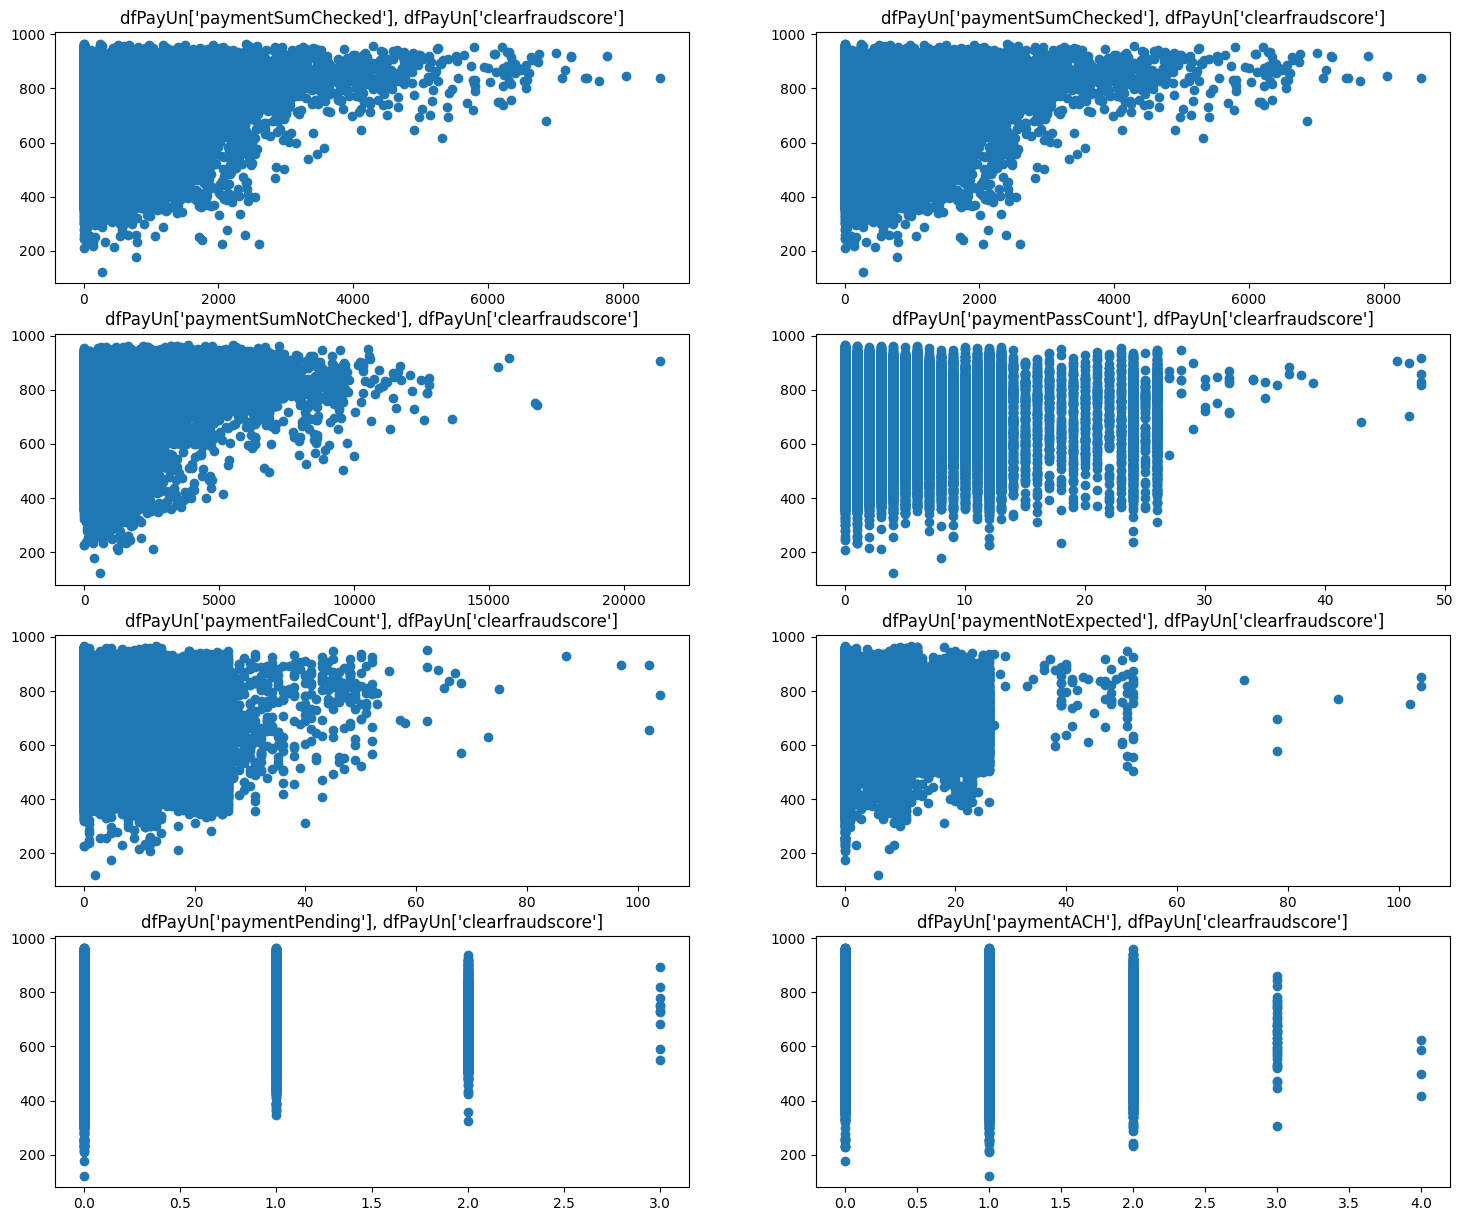

In [26]:
"""
Visualizing payment engineered features against clear fraudscore
"""
fig, axes = plt.subplots(4, 2,figsize=(18, 15))

axes[0, 0].scatter(dfPayUn['paymentSumChecked'], dfPayUn['clearfraudscore'])
axes[0, 0].set_title("dfPayUn['paymentSumChecked'], dfPayUn['clearfraudscore']")

axes[0, 1].scatter(dfPayUn['paymentSumChecked'], dfPayUn['clearfraudscore'])
axes[0, 1].set_title("dfPayUn['paymentSumChecked'], dfPayUn['clearfraudscore']")

axes[1, 0].scatter(dfPayUn['paymentSumNotChecked'], dfPayUn['clearfraudscore'])    
axes[1, 0].set_title("dfPayUn['paymentSumNotChecked'], dfPayUn['clearfraudscore']")    

axes[1, 1].scatter(dfPayUn['paymentPassCount'], dfPayUn['clearfraudscore'])
axes[1, 1].set_title("dfPayUn['paymentPassCount'], dfPayUn['clearfraudscore']")

axes[2, 0].scatter(dfPayUn['paymentFailedCount'], dfPayUn['clearfraudscore'])
axes[2, 0].set_title("dfPayUn['paymentFailedCount'], dfPayUn['clearfraudscore']")

axes[2, 1].scatter(dfPayUn['paymentNotExpected'], dfPayUn['clearfraudscore'])
axes[2, 1].set_title("dfPayUn['paymentNotExpected'], dfPayUn['clearfraudscore']")

axes[3, 0].scatter(dfPayUn['paymentPending'], dfPayUn['clearfraudscore'])
axes[3, 0].set_title("dfPayUn['paymentPending'], dfPayUn['clearfraudscore']")

axes[3, 1].scatter(dfPayUn['paymentACH'], dfPayUn['clearfraudscore'])
axes[3, 1].set_title("dfPayUn['paymentACH'], dfPayUn['clearfraudscore']")


## MERGING PAYMENT TABLE TO LOAN + UNDERWRITING TABLE

In [27]:
dfLUP = pd.merge(dfLU,
                 dfNewPayment,
                 right_on='loanId', left_on = "loanId",
                 how='left')

dfLUP.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,fpStatusCategories,clearfraudscore,underwritingid,paymentSumChecked,paymentSumNotChecked,paymentPassCount,paymentFailedCount,paymentNotExpected,paymentPending,paymentACH
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,successful,879.0,569eb3a3e4b096699f685d64,6287.08,799.39,22,3,0,0,0
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Engineering Additional features

In [28]:
dfLUP.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,fpStatusCategories,clearfraudscore,underwritingid,paymentSumChecked,paymentSumNotChecked,paymentPassCount,paymentFailedCount,paymentNotExpected,paymentPending,paymentACH
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23 17:29:01.940,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,successful,879.0,569eb3a3e4b096699f685d64,6287.08,799.39,22,3,0,0,0
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01 13:51:14.709,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06 23:58:08.880,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05 22:31:34.304,False,NaT,0.0,False,0,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
"""
# Strategy to create additional features
"""
# For each annon_ssn:
# number of locations for each annon_ssn
# Variance in the loans requested total amount (within 24 hours)
# Variance between each transation time / duration 
# Number transactions in the past 24 hours
# Sum of transactions in the past 24 hours
# Number of transactions in the same location in the past 24 hours

'\n# Strategy to create additional features\n'

In [31]:
"""
# Feature engineering the standard deviation between consecutive transactions of an anon_ssn. 
# Basis is that high consevutive transaction / loan requests have higher tendancy of fraud. 
"""

# ssnData
# Average duration between consecutive transactions
# # if there is only 1 transaction then 0
# ssnConsecutiveTransactionDuration = {}
# for key in tqdm(ssnData):
#     ssnConsecutiveTransactionDuration[key] = []
#     filteredData = dfLUP.loc[dfLUP.anon_ssn == key]
#     filteredData = filteredData.sort_values(by = ["applicationDate"],ascending = True,ignore_index = True)
#     if filteredData.shape[0] > 1: 
#         for index, row in filteredData.iterrows():
#             if index != 0: 
#                 timeDiff = filteredData.applicationDate[index] - filteredData.applicationDate[index-1]
#                 ssnConsecutiveTransactionDuration[key].append(timeDiff / np.timedelta64(1, 'h'))
#         ssnConsecutiveTransactionDuration[key] = statistics.pstdev(ssnConsecutiveTransactionDuration[key])
#     else: 
#         ssnConsecutiveTransactionDuration[key] = 0        

# # Saving processed data
# json_object = json.dumps(ssnConsecutiveTransactionDuration, indent = 4) 
# with open("./derivedData/ssnConsecutiveTransactionDuration.json", "w") as outfile:
#     json.dump(ssnConsecutiveTransactionDuration, outfile)

# Opening and reading processed data. 
f = open('./derivedData/ssnConsecutiveTransactionDuration.json')
ssnConsecutiveTransactionDurationData = json.load(f)
f.close()


In [32]:
"""
# Feature engineering the number of locations associated to an anon_ssn
# Basis is that high number of locations for an anon_ssn has high tendancy of fraud. 
"""

# number of locations for each annon_ssn
# ssnLocations = {}
# for key in tqdm(ssnData):
#     ssnLocations[key] = 0
#     ssnLocations[key] += len(dfLUP.loc[dfLUP.anon_ssn == key]["state"].dropna(axis = 0).unique())

# # Saving processed data
# json_object = json.dumps(ssnLocations, indent = 4) 
# with open("./derivedData/ssnLocations.json", "w") as outfile:
#     json.dump(ssnLocations, outfile)

# Opening and reading processed data
f = open('./derivedData/ssnLocations.json')
ssnLocationsData = json.load(f)
f.close()

In [33]:
"""
# Feature engineering the standard deviation in loan values by an anon_ssn
# Basis is that high deviation in loan values typically can be fraud
"""

# Variance in the loans requested total amount (within 24 hours)
# ssnLoanAmountVariation = {}
# for key in tqdm(ssnData):
#     ssnLoanAmountVariation[key] = 0
#     filteredData = list(dfLUP.loc[dfLUP.anon_ssn == key]["loanAmount"].dropna(axis = 0))
#     if filteredData == []:
#         ssnLoanAmountVariation[key] = 0
#     else: 
#         ssnLoanAmountVariation[key] = statistics.pstdev(list(filteredData)) 

# # Saving Processed data 
# json_object = json.dumps(ssnLoanAmountVariation, indent = 4) 
# with open("./derivedData/ssnLoanAmountVariation.json", "w") as outfile:
#     json.dump(ssnLoanAmountVariation, outfile)

# Open and read processed data
f = open('./derivedData/ssnLoanAmountVariation.json')
ssnLoanAmountVariationData = json.load(f)
f.close()

## Segregating Categorical Features VS numerical features

In [34]:
# Categorical Features (# kendall / anova):
# state	
# originated	
# approved	 
# isFunded	
# loanStatus
# leadType	
# fpStatus
# hasCF	
# fpStatusCategories
# oriAppFund 

# Numerical Features (pearson / Spearman)
# payFrequency
# apr	
# nPaidOff		
# loanAmount	
# originallyScheduledPaymentAmount	
# leadCost	
# originDuration	
# ssnCount 
# paymentSumChecked	
# paymentSumNotChecked	
# paymentPassCount	
# paymentFailedCount	
# paymentNotExpected	
# paymentPending	
# paymentACH	

# Target Variable
# clearfraudscore	

In [35]:
"""
# Checking the missing values for all columns
"""
pd.DataFrame(data = dfLUP.isna().sum(),columns = ["MissingValueCount"])

,MissingValueCount
loanId,105
anon_ssn,0
payFrequency,1190
apr,1399
applicationDate,0
originated,0
originatedDate,318453
nPaidOff,2
approved,0
isFunded,0


In [36]:
"""
# Removing unwanted columns based on preliminary analysis of missing values concentration
# Detailed missing values handling for clear are in subsequent sections below
"""

columnsRemove = ["loanId", "anon_ssn", "applicationDate", "originatedDate", "clarityFraudId", "underwritingid"]
dfLUPFinal = dfLUP.drop(labels = columnsRemove, axis = 1)

"""
DECISION ON DATA COLUMNS
# loanId	7 -- REMOVING COLUMN ENTIRELY
# anon_ssn	0 -- REMOVING COLUMN ENTIRELY
# payFrequency	104 -- REMOVE THE 
# apr	17              -- Check for others with the same LoanAmount (bandwidth) within the same state
# applicationDate	0   -- REMOVE COLUMN ENTIRELY
# originated	0
# originatedDate	3845 -- REMOVE COLUMN ENTIRELY
# nPaidOff	2        -- Set to 0
# approved	0 
# isFunded	0
# loanStatus	11       -- Set to unknown since it's categorical
# loanAmount	17       -- Remove the rows 
# originallyScheduledPaymentAmount	0
# state	13           -- Set as unknown? 
# leadType	0
# leadCost	0
# fpStatus	3862     -- Set as unknown
# clarityFraudId	 -- REMOVE COLUMN ENTIRELY
# hasCF	0
# originDuration	3845 -- Set to 0
# ssnCount	0
# oriAppFund	0
# fpStatusCategories	0
# clearfraudscore	0
# underwritingid	0  -- REMOVE COLUMN ENTIRELY
# paymentSumChecked	4006     --set 0
# paymentSumNotChecked	4006 --set 0
# paymentPassCount	4006     --set 0 
# paymentFailedCount	4006     --set 0
# paymentNotExpected	4006     --set 0
# paymentPending	4006         --set 0
# paymentACH	4006             --set 0
"""

"\nDECISION ON DATA COLUMNS\n# loanId\t7 -- REMOVING COLUMN ENTIRELY\n# anon_ssn\t0 -- REMOVING COLUMN ENTIRELY\n# payFrequency\t104 -- REMOVE THE \n# apr\t17              -- Check for others with the same LoanAmount (bandwidth) within the same state\n# applicationDate\t0   -- REMOVE COLUMN ENTIRELY\n# originated\t0\n# originatedDate\t3845 -- REMOVE COLUMN ENTIRELY\n# nPaidOff\t2        -- Set to 0\n# approved\t0 \n# isFunded\t0\n# loanStatus\t11       -- Set to unknown since it's categorical\n# loanAmount\t17       -- Remove the rows \n# originallyScheduledPaymentAmount\t0\n# state\t13           -- Set as unknown? \n# leadType\t0\n# leadCost\t0\n# fpStatus\t3862     -- Set as unknown\n# clarityFraudId\t -- REMOVE COLUMN ENTIRELY\n# hasCF\t0\n# originDuration\t3845 -- Set to 0\n# ssnCount\t0\n# oriAppFund\t0\n# fpStatusCategories\t0\n# clearfraudscore\t0\n# underwritingid\t0  -- REMOVE COLUMN ENTIRELY\n# paymentSumChecked\t4006     --set 0\n# paymentSumNotChecked\t4006 --set 0\n# payme

In [39]:
CategoricalFeatures = ["state","originated","approved","isFunded","loanStatus","leadType","fpStatus","hasCF","fpStatusCategories","oriAppFund","payFrequency"]
NumericalFeatures = ["apr","nPaidOff","loanAmount","originallyScheduledPaymentAmount","leadCost","originDuration","ssnCount","paymentSumChecked","paymentSumNotChecked","paymentPassCount","paymentFailedCount","paymentNotExpected","paymentPending","paymentACH"]
targetVariable = ["clearfraudscore"]
dfLUPCategorical = dfLUPFinal[CategoricalFeatures + targetVariable]
dfLUPNumerical = dfLUPFinal[NumericalFeatures + targetVariable]

# dfLUPFinal.to_csv("./derivedData/dfLUPFinal.csv",index = False)
# dfLUPCategorical.to_csv("./derivedData/dfLUPCategorical.csv",index = False)
# dfLUPNumerical.to_csv("./derivedData/dfLUPNumerical.csv",index = False)

dfLUPFinal = pd.read_csv("./derivedData/dfLUPFinal.csv")
dfLUPCategorical = pd.read_csv("./derivedData/dfLUPCategorical.csv")
dfLUPNumerical = pd.read_csv("./derivedData/dfLUPNumerical.csv")

## Handling Missing Values - clearfraudscore

clearfraudscore

- IT WAS NOTICED THAT THE TARGET VARIABLE clearfraudscore HAS A HIGH AMOUNT OF MISSING VALUES. 
- Based on analysis no other variable / feature can substitute the clearfraudscore
- Decision way forward is to try and fill up those missing values systematically

Handling of remaining missing values are detailed in following sections 

In [40]:
"""
# Visualize remaining rows if missing clearfraudscore rows were removed
# remaining rows left after removal is too low. 
# Strategy way forward is to impute the missing rows. 
"""
# Case where we remove the NAN rows of clearFraudScore
print(dfLUP.shape[0] - dfLUP.dropna(subset = ["clearfraudscore"],axis=0).shape[0])
pd.DataFrame(dfLUP.dropna(subset = ["clearfraudscore"],axis=0).isna().sum(),columns = ["MissingValueCount"])

321468


,MissingValueCount
loanId,7
anon_ssn,0
payFrequency,104
apr,17
applicationDate,0
originated,0
originatedDate,3845
nPaidOff,2
approved,0
isFunded,0


In [41]:
"""
# STRATEGY 1
# Imputing Missing Clear Fraud Scores based on common anon_ssn
# Steps: 
# 1. Get anon_ssn with missing clearfraudscore
# 2. Check entire datset for common anon_ssn with clearfraudscore
# 3. For all non-zero / non-nan values obtained, calculate the average clearfraudscore
# 4. Impute missing cell value
"""

# ssnClearFraudScore = {}
# for val in dfLUP.anon_ssn.unique(): 
#     if val not in ssnClearFraudScore.keys():
#         ssnClearFraudScore[val]  = []
#     else:
#         pass

# for key in tqdm(ssnClearFraudScore.keys()):
#     fitleredData = list(dfLUP.loc[dfLUP.anon_ssn == key]["clearfraudscore"])
#     ssnClearFraudScore[key] += fitleredData

# # Save processed DATA as JSON
# json_object = json.dumps(ssnClearFraudScore, indent = 4) 
# with open("./derivedData/ssnClearFraudScore.json", "w") as outfile:
#     json.dump(ssnClearFraudScore, outfile)

# Opening and reading saved data
f = open('./derivedData/ssnClearFraudScore.json')
ssnClearFraudScoreData = json.load(f)
f.close()

# Filter out only anon_ssns with non-missing clearfraudscore
for key in ssnClearFraudScoreData.keys(): 
    ssnClearFraudScoreData[key] = [el for el in list(set(ssnClearFraudScoreData[key])) if el >=0]

# Visualization
ssnClearFraudScoreData

{'beff4989be82aab4a5b47679216942fd': [],
 '464f5d9ae4fa09ece4048d949191865c': [879.0],
 '3c174ae9e2505a5f9ddbff9843281845': [],
 '9be6f443bb97db7e95fa0c281d34da91': [],
 '63b5494f60b5c19c827c7b068443752c': [],
 'b5541f49472fa0fce8e473306768f7fb': [],
 '1828c64bb2dffeae88b27174a9f79ecc': [],
 '523ed92e1145eb688bb631da24695197': [],
 '47bf79119075e41ef65510f2900c8e4a': [],
 'd7fa2d3cdff861249f57644e1050334a': [],
 '2f90cd4d32d373e4c044a67fc4b9cb88': [],
 '50e168ad9d93f7ee73e5f041822bd8dd': [],
 '8f3bd2f82d48d6e3b221247be473d2e9': [],
 '26a324e10d76a083c4d1e285355f36be': [],
 'dfc62c0d82a253f004abcb3482d163f5': [],
 'e0986defb3ba01328f794610bbb29d98': [],
 '2b8352dbdef42c27292d45163d69c608': [],
 '77211941bdca076c298fa7b5e8176a05': [],
 '6be6ee501a5dd62f716a0576c8bb609c': [],
 '181a0fca52b76604999c13a3d3bf5d5b': [],
 '9c2f22e0b000a23c193d85efccfc1741': [],
 '7b837a8178010c7d7ed841ed5b1d8d22': [],
 '2de690f22e9ff8a2eae4ef62158199c3': [],
 'eecead70631ba3f21b74a5c63d29c9ff': [],
 '7529d29c9

In [42]:
dfLUP.loc[dfLUP.clearfraudscore.isna()].shape

(321468, 32)

In [43]:
"""
# Imputing clear fraud score using generated ssnClearFraudScoreData dictionary. 
"""

def my_filtering_function(pair):
    unwanted_value = []
    key, value = pair
    if value == unwanted_value:
        return False  # filter pair out of the dictionary
    else:
        return True  # keep pair in the filtered dictionary
nonNanSsn = dict(filter(my_filtering_function, ssnClearFraudScoreData.items()))
dfLUP.loc[dfLUP.clearfraudscore.isna() & dfLUP.anon_ssn.isin(nonNanSsn.keys())].shape
# By using anon_ssn to impute the clearfraudscore we can recover 2277 rows of data

for ssn in dfLUP.loc[dfLUP.clearfraudscore.isna()].anon_ssn:
    if ssn in nonNanSsn.keys():
        targetIdx = dfLUP.loc[(dfLUP.clearfraudscore.isna()) & (dfLUP.anon_ssn==ssn)]["clearfraudscore"].index        
        dfLUP["clearfraudscore"][targetIdx] = sum(nonNanSsn[ssn]) / len(nonNanSsn[ssn])

In [46]:
"""
# STRATEGY 2
# Imputing clearfraudscore based on common feature scoring
# For each row of missing clearfraudscore, the following was done
# 1. 10 features were selected to match the missing row data to another similar matching row. 
# 2. Features were payFrequency, apr, loanAmount, state, leadType, leadCost, fpStatus, oriAppFund, fpStatusCategories
# 3. Features comprised of categorical and numerical features
# 4. For categorical features, each feature column direct match gets a score of 1
# 5. For numerical features, each feature column matching by calculating a +/- 15% deviation from the value. If the missing row value is within the range the scoring +=1 is given
# 6. A total scoring of 5 is required to match a missing row to another row. 
# 7. All rows (non-zeros) matching the desired row to impute (nan row) are gathered and clear fraud score is averaged to impute the missing row clearfraudscore
"""

# length = len(dfLUP.loc[dfLUP.clearfraudscore.isna()])
# print(length)

# # Filling up missing data
# for index,row in tqdm(dfLUP.loc[dfLUP.clearfraudscore.isna()].iterrows()):
#     # features of the missing clearfraudscore row
#     rowPayfrequency = row.payFrequency
#     rowApr = row.apr
#     rowLoanAmount = row.loanAmount
#     rowState = row.state
#     rowLeadType = row.leadType
#     rowLeadCost = row.leadCost
#     rowFpStatus = row.fpStatus
#     rowOriAppFund = row.oriAppFund
#     rowFpStatusCategory = row.fpStatusCategories
    
#     # Data with non missing values
#     filteredData = dfLUP.loc[~dfLUP.clearfraudscore.isna()]

#     # find rows that intersect 
#     # Take the clear fraud score from those rows 
#     #  Impute

#     # Locate rows that match for each feature and get their index
#     matchPayFrequency = filteredData.loc[filteredData.payFrequency == rowPayfrequency].index
#     matchApr = filteredData.loc[(filteredData.apr >= rowApr - 0.15*rowApr) & (filteredData.apr <= rowApr + 0.15*rowApr)].index
#     matchLoanAmount = filteredData.loc[(filteredData.loanAmount >= rowLoanAmount - 0.15*rowLoanAmount) & (filteredData.loanAmount <= rowLoanAmount + 0.15*rowLoanAmount)].index
#     matchState = filteredData.loc[filteredData.state == rowState].index
#     matchLeadType = filteredData.loc[filteredData.leadType == rowLeadType].index
#     matchLeadCost = filteredData.loc[(filteredData.leadCost >= rowLeadCost - 0.15 * rowLeadCost) & (filteredData.leadCost <= rowLeadCost + 0.15 * rowLeadCost)].index
#     matchFpStatus = filteredData.loc[filteredData.fpStatus == rowFpStatus].index
#     matchOriAppFund = filteredData.loc[filteredData.oriAppFund == rowOriAppFund].index
#     matchFpStatusCategory = filteredData.loc[filteredData.fpStatusCategories == rowFpStatusCategory].index

#     potentialRowFix = []
#     # Combine all of the indexes
#     matchAll = list(matchPayFrequency) + list(matchApr) + list(matchLoanAmount) + list(matchState) + list(matchLeadType) + list(matchLeadCost) + list(matchFpStatus) + list(matchOriAppFund) + list(matchFpStatusCategory)
#     # Get a counter of the indexes occurences as scoring
#     indexDict = {}
#     for vals in set(matchAll):
#       indexDict[vals] = 0
#     for vals in matchAll:
#       indexDict[vals] += 1

#     # Set a threshold score of 5 to take the potential row as candidate for imputation. Then save the row's index
#     for key in indexDict.keys():
#       if indexDict[key] >= 5: 
#         potentialRowFix.append(key)

#     # Get the clearfraudscore of the indices and calculate their average
#     clearFraudImpute = list(dfLUP.loc[dfLUP.index.isin(potentialRowFix)]["clearfraudscore"])
#     imputeVal = sum(clearFraudImpute) / len(clearFraudImpute)

#     # If the returned / calculated value is more than 0 / 
#     if imputeVal > 0:
#       dfLUP["clearfraudscore"][index] = imputeVal

# # Saving data
# dfLUP.to_csv("./derivedData/dfLUPFinalImputed.csv",index = False)
# dfLUP

# Opening and Reading data
dfLUP = pd.read_csv("./derivedData/dfLUPFinalImputed.csv")
columnsRemove = ["loanId", "anon_ssn", "applicationDate", "originatedDate", "clarityFraudId", "underwritingid"]
dfLUPFinal = dfLUP.drop(labels = columnsRemove, axis = 1)

In [47]:
# Checking missing values after imputation
dfLUPFinal.isna().sum()

payFrequency                          1190
apr                                   1399
originated                               0
nPaidOff                                 2
approved                                 0
isFunded                                 0
loanStatus                             195
loanAmount                            1352
originallyScheduledPaymentAmount         0
state                                  130
leadType                                 0
leadCost                                 0
fpStatus                            317847
hasCF                                    0
originDuration                      318453
ssnCount                                 0
oriAppFund                               0
fpStatusCategories                       0
clearfraudscore                          0
paymentSumChecked                   324439
paymentSumNotChecked                324439
paymentPassCount                    324439
paymentFailedCount                  324439
paymentNotE

# Data Prepping for Model Development

- Encoding Categorical Features
- Handling remaining missing values for numerical and categorical features
- Representing categorical features as an embedding
- Split data into training and testing
- Data normalization

In [48]:
# Creating numerical and categorical feature sets
CategoricalFeatures = ["state","originated","approved","isFunded","loanStatus","leadType","fpStatus","hasCF","fpStatusCategories","oriAppFund","payFrequency"]
NumericalFeatures = ["apr","nPaidOff","loanAmount","originallyScheduledPaymentAmount","leadCost","originDuration","ssnCount","paymentSumChecked","paymentSumNotChecked","paymentPassCount","paymentFailedCount","paymentNotExpected","paymentPending","paymentACH"]
targetVariable = ["clearfraudscore"]
dfLUPCategorical = dfLUPFinal[CategoricalFeatures + targetVariable]
dfLUPNumerical = dfLUPFinal[NumericalFeatures + targetVariable]

### Categorical Features

In [50]:
"""
# Ordinal Encoding categorical features and calculating feature relavance using f_classif scoring
"""

categoricalFeatureScoringF = {}
categoricalFeatureScoringP = {}
categoricalFeatureEncoder = {}

for col in CategoricalFeatures: 
    categoricalFeatureScoringF[col] = 0
    categoricalFeatureScoringP[col] = 0
    categoricalFeatureEncoder[col] = None

for col in CategoricalFeatures: 
    # Create encoder
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=dfLUPCategorical[col].dropna().nunique()+1)           # Ordinal encoder sets unknown values to a new category known as unknown. 
    ordinal_encoder.fit(np.array(dfLUPCategorical[col].dropna()).reshape(-1,1))
    categoricalFeatureEncoder[col] = ordinal_encoder
    filteredData = dfLUPCategorical.loc[~dfLUPCategorical.clearfraudscore.isna()]
    shapeSize = filteredData.shape[0]
    transformedVariable = ordinal_encoder.transform(np.array(filteredData[col]).reshape(-1,1)).reshape(shapeSize,)    

    val1 = transformedVariable
    val2 = np.array(filteredData.clearfraudscore).reshape(shapeSize,)
    fvalue,pvalue = f_classif(val1.reshape(-1,1), val2.reshape(-1,1))
    categoricalFeatureScoringF[col] += fvalue
    categoricalFeatureScoringP[col] += pvalue   

In [51]:
"""
# Removing features that are deemed not relevant based on statistical analysis
"""
dfLUPCategoricalTarget = dfLUPCategorical["clearfraudscore"]
dfLUPCategoricalFeatures = dfLUPCategorical.drop(["clearfraudscore","fpStatus","hasCF"],axis = 1)      # Dropped features
# dfLUPCategoricalFeatures.isna().sum()
dfLUPCategoricalFeatures.nunique().sum()

88

In [52]:
"""
# Encoding the features with Label Encoding
"""
dfLUPFinalEncodedFeatures = copy.deepcopy(dfLUPCategoricalFeatures)
for col in dfLUPCategoricalFeatures: 
    enc = categoricalFeatureEncoder[col]
    shapeSize = dfLUPFinalEncodedFeatures.shape[0]
    dfLUPFinalEncodedFeatures[col] = enc.transform(np.array(dfLUPFinalEncodedFeatures[col]).reshape(-1,1)).reshape(shapeSize,)    
dfLUPFinalEncodedFeatures.head(3)

,state,originated,approved,isFunded,loanStatus,leadType,fpStatusCategories,oriAppFund,payFrequency
0,12.0,0.0,0.0,0.0,17.0,0.0,2.0,3.0,0.0
1,3.0,1.0,1.0,1.0,9.0,7.0,1.0,1.0,0.0
2,19.0,0.0,0.0,0.0,17.0,0.0,2.0,3.0,0.0


#### Embedding Model without OH encoding

Given that there are high numbers of categorical features with high number of categories, it would lead to very sparse matrix. 

To tackle this we convert the categorical feature columns using an embedding network that would represent the input categorical features

Embedding is done using tensorflow with 10 columns

In [53]:
# Fit the model without OH encoding
embedding = Embedding(input_dim=100, # set input shape
                             output_dim=200, # set size of embedding vector
                             embeddings_initializer="glorot_uniform", # default, intialize randomly
                             input_length=dfLUPFinalEncodedFeatures.shape[1], # how long is each input
                             name="embedding_1") 
inputs = Input(shape = (9,))
embedding = embedding(inputs)
x = Dense(15,activation = "tanh")(embedding)
x = Dense(5,activation = "tanh")(x)
x = Flatten()(x)
x = Dense(10,activation = "tanh")(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = Dense(1,activation = "tanh")(x)
model_1 = tf.keras.Model(inputs,outputs = [outputs,],name="testModel1")
# Compile model
model_1.compile(loss="mse",
                optimizer="SGD",
                metrics="mae")
model_1.summary()
history = model_1.fit(dfLUPFinalEncodedFeatures, dfLUPCategoricalTarget, epochs=50, verbose=1,batch_size=64)


Model: "testModel1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 9, 200)            20000     
                                                                 
 dense (Dense)               (None, 9, 15)             3015      
                                                                 
 dense_1 (Dense)             (None, 9, 5)              80        
                                                                 
 flatten (Flatten)           (None, 45)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                460       
                                                                 
 batch_normalization (BatchN  (None, 10)               4

In [54]:
# Extracting the embedding and saving them
XX = model_1.input 
YY = model_1.layers[-2].output
embeddingModel1 = Model(XX, YY)
Xaug = dfLUPFinalEncodedFeatures[:]
Xresult = embeddingModel1.predict(Xaug)
embeddingData =  pd.DataFrame(Xresult)
embeddingData.to_csv("./derivedData/embeddingData.csv",index = False)
embeddingData = pd.read_csv("./derivedData/embeddingData.csv")

11178/11178 [==============================] - 5s 468us/step


#### Embedding with OH Encoder - tanh internal activation

In [55]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
#perform one-hot encoding on 'team' column 
encoderOH_df = pd.DataFrame(encoder.fit_transform(dfLUPFinalEncodedFeatures).toarray())
encoderOH_df.head()
encoderOH_df.to_csv("./derivedData/encoderOH_df.csv",index=False)
encoderOH_df = pd.read_csv("./derivedData/encoderOH_df.csv")

In [56]:
# Fit the model with OH encoding
embedding = Embedding(input_dim=100, # set input shape
                             output_dim=200, # set size of embedding vector
                             embeddings_initializer="glorot_uniform", # default, intialize randomly
                             input_length=encoderOH_df.shape[1], # how long is each input
                             name="embedding_2") 
inputs = Input(shape = (91,))
embedding = embedding(inputs)
x = Dense(15,activation = "tanh")(embedding)
x = Dense(5,activation = "tanh")(x)
x = Flatten()(x)
x = Dense(10,activation = "tanh")(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = Dense(1,activation = "tanh")(x)
model_2 = tf.keras.Model(inputs,outputs,name="testModel2")
# Compile model
model_2.compile(loss="mse",
                optimizer="SGD",
                metrics="mae")
history_2 = model_2.fit(encoderOH_df, dfLUPCategoricalTarget, epochs=50, verbose=1,batch_size=64)

Epoch 1/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417015.7812 - mae: 644.0952
Epoch 2/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417016.0938 - mae: 644.0940
Epoch 3/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417016.1250 - mae: 644.0952
Epoch 4/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417015.0000 - mae: 644.0939
Epoch 5/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417015.9062 - mae: 644.0938
Epoch 6/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417015.9688 - mae: 644.0946
Epoch 7/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417015.8750 - mae: 644.0945
Epoch 8/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417016.5938 - mae: 644.0942
Epoch 9/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417016.0938 - mae: 644.0937
Epoch 10/50
5589/5589 [==============================] 

In [57]:
# Extracting the embedding and saving them
AA = model_2.input 
BB = model_2.layers[-2].output
embeddingModel2 = Model(AA, BB)
Xaug = encoderOH_df[:]
Xresult = embeddingModel2.predict(Xaug)
embeddingDataOH =  pd.DataFrame(Xresult)
embeddingDataOH.head()
embeddingDataOH.to_csv('./derivedData/embeddingDataOH.csv',index=False)
embeddingDataOH = pd.read_csv("./derivedData/embeddingDataOH.csv")

11178/11178 [==============================] - 15s 1ms/step


In [58]:
embeddingDataOHCols = ["emb_" + col for col in embeddingDataOH.columns]
embeddingDataOH.columns = embeddingDataOHCols

#### Embedding with OH Encoder - ReLu internal activation

In [59]:
# Fit the model with OH encoding
embedding = Embedding(input_dim=100, # set input shape
                             output_dim=200, # set size of embedding vector
                             embeddings_initializer="glorot_uniform", # default, intialize randomly
                             input_length=encoderOH_df.shape[1], # how long is each input
                             name="embedding_3") 
inputs = Input(shape = (91,))
embedding = embedding(inputs)
x = Dense(15,activation = "relu")(embedding)
x = Dense(5,activation = "relu")(x)
x = Flatten()(x)
x = Dense(10,activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = Dense(1,activation = "tanh")(x)
model_3 = tf.keras.Model(inputs,outputs,name="testModel3")
# Compile model
model_3.compile(loss="mse",
                optimizer="SGD",
                metrics="mae")
history_3 = model_3.fit(encoderOH_df, dfLUPCategoricalTarget, epochs=50, verbose=1,batch_size=64)

Epoch 1/50
5589/5589 [==============================] - 22s 4ms/step - loss: 417016.0312 - mae: 644.0964
Epoch 2/50
5589/5589 [==============================] - 20s 4ms/step - loss: 417015.4062 - mae: 644.0936
Epoch 3/50
5589/5589 [==============================] - 18s 3ms/step - loss: 417016.0312 - mae: 644.0945
Epoch 4/50
5589/5589 [==============================] - 18s 3ms/step - loss: 417015.9688 - mae: 644.0946
Epoch 5/50
5589/5589 [==============================] - 18s 3ms/step - loss: 417015.2188 - mae: 644.0928
Epoch 6/50
5589/5589 [==============================] - 18s 3ms/step - loss: 417016.5625 - mae: 644.0942
Epoch 7/50
5589/5589 [==============================] - 18s 3ms/step - loss: 417015.0000 - mae: 644.0943
Epoch 8/50
5589/5589 [==============================] - 18s 3ms/step - loss: 417015.4062 - mae: 644.0935
Epoch 9/50
5589/5589 [==============================] - 19s 3ms/step - loss: 417015.6250 - mae: 644.0948
Epoch 10/50
5589/5589 [==============================] 

In [60]:
# Extracting the embedding and saving them
AA = model_3.input 
BB = model_3.layers[-2].output
embeddingModel3 = Model(AA, BB)
Xaug = encoderOH_df[:]
Xresult = embeddingModel3.predict(Xaug)
embeddingDataOH_ReLu =  pd.DataFrame(Xresult)
embeddingDataOH_ReLu.head()
embeddingDataOH_ReLu.to_csv('./derivedData/embeddingDataOH_ReLu.csv',index=False)
embeddingDataOH_ReLu = pd.read_csv("./derivedData/embeddingDataOH_ReLu.csv")

11178/11178 [==============================] - 15s 1ms/step


In [61]:
embeddingDataOHCols = ["emb_" + col for col in embeddingDataOH.columns]
embeddingDataOH_ReLu.columns = embeddingDataOHCols

### Numerical Features

In [62]:
dfLUPNumerical = dfLUPNumerical.fillna(0)

In [63]:
"""
# Calculating feature importance scoring for numerical feature using Pearson Correlation scoring
"""

# numericalFeatureScoring = {}
# for col in NumericalFeatures:
#     print(col)
#     corr, _ = pearsonr(dfLUPNumerical[col].astype("float64"),dfLUPNumerical[targetVariable].astype("float64")) 
#     # numericalFeatureScoring[col] = corr[0]
# numericalFeatureScoring = dict(sorted(numericalFeatureScoring.items(), key = lambda x:x[1], reverse = True))

'\n# Calculating feature importance scoring for numerical feature using Pearson Correlation scoring\n'

In [64]:
dfLUPNumericalFinal = dfLUPNumerical.drop(["paymentACH","originDuration","ssnCount"],axis = 1)
dfLUPNumericalFinal
# From statistical testing (pearson correlation scoring) it was identified that paymentACH, originDuration and ssnCount to be least significant and hence are removed. 

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,paymentSumChecked,paymentSumNotChecked,paymentPassCount,paymentFailedCount,paymentNotExpected,paymentPending,clearfraudscore
0,360.0,0.0,500.0,978.27,6,0.00,0.00,0.0,0.0,0.0,0.0,649.962308
1,199.0,0.0,3000.0,6395.19,0,6287.08,799.39,22.0,3.0,0.0,0.0,879.000000
2,590.0,0.0,400.0,1199.45,3,0.00,0.00,0.0,0.0,0.0,0.0,607.681941
3,360.0,0.0,500.0,1074.05,3,0.00,0.00,0.0,0.0,0.0,0.0,649.532761
4,590.0,0.0,350.0,814.37,3,0.00,0.00,0.0,0.0,0.0,0.0,612.806555
...,...,...,...,...,...,...,...,...,...,...,...,...
357688,590.0,0.0,900.0,2534.33,10,0.00,0.00,0.0,0.0,0.0,0.0,636.512355
357689,590.0,0.0,400.0,1292.41,3,0.00,0.00,0.0,0.0,0.0,0.0,633.455533
357690,490.0,0.0,1000.0,2592.39,25,0.00,0.00,0.0,0.0,0.0,0.0,665.703160
357691,590.0,0.0,300.0,844.75,6,0.00,0.00,0.0,0.0,0.0,0.0,634.507044


### Consolidating Numerical and Categorical Data

In [65]:
"""
# Data with internal tanh activation
"""
dfFinalMerge = pd.concat([dfLUPNumericalFinal, embeddingDataOH], axis = 1)
dfFinalMerge.head()

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,paymentSumChecked,paymentSumNotChecked,paymentPassCount,paymentFailedCount,paymentNotExpected,...,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9
0,360.0,0.0,500.0,978.27,6,0.00,0.00,0.0,0.0,0.0,...,-4.063079,-5.691426,1.103447,0.228962,1.043316,5.190009,-0.224144,6.112023,-3.105659,-3.430305
1,199.0,0.0,3000.0,6395.19,0,6287.08,799.39,22.0,3.0,0.0,...,-4.757064,-10.002221,2.528361,0.516285,1.839563,7.256310,-1.145596,9.353476,-3.778744,-4.226510
2,590.0,0.0,400.0,1199.45,3,0.00,0.00,0.0,0.0,0.0,...,-3.796389,-5.691430,-0.298154,0.408508,-1.489767,5.190430,-0.400100,6.112042,-3.105934,-3.430321
3,360.0,0.0,500.0,1074.05,3,0.00,0.00,0.0,0.0,0.0,...,-4.063079,-5.691426,1.103447,0.228962,1.043316,5.190009,-0.224144,6.112023,-3.105659,-3.430305
4,590.0,0.0,350.0,814.37,3,0.00,0.00,0.0,0.0,0.0,...,-4.510162,-5.692363,2.068952,0.363419,-1.087678,5.310460,-0.814038,6.113042,-3.113354,-3.430734


In [66]:
"""
# Data with internal relu activation
"""
dfFinalMergeReLu = pd.concat([dfLUPNumericalFinal, embeddingDataOH_ReLu], axis = 1)
dfFinalMergeReLu.head()

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,paymentSumChecked,paymentSumNotChecked,paymentPassCount,paymentFailedCount,paymentNotExpected,...,emb_emb_0,emb_emb_1,emb_emb_2,emb_emb_3,emb_emb_4,emb_emb_5,emb_emb_6,emb_emb_7,emb_emb_8,emb_emb_9
0,360.0,0.0,500.0,978.27,6,0.00,0.00,0.0,0.0,0.0,...,-6.739871,-4.548157,0.355087,-2.219906,-1.960465,0.406672,4.04309,2.071982,-1.430605,-2.966916
1,199.0,0.0,3000.0,6395.19,0,6287.08,799.39,22.0,3.0,0.0,...,-6.739871,-4.626587,-1.854084,-2.219906,-1.960465,1.208368,4.04309,1.019725,0.131369,-2.049434
2,590.0,0.0,400.0,1199.45,3,0.00,0.00,0.0,0.0,0.0,...,-6.739871,-5.073334,-0.036476,-2.219906,-1.960465,0.300245,4.04309,1.497154,-0.958362,-2.675316
3,360.0,0.0,500.0,1074.05,3,0.00,0.00,0.0,0.0,0.0,...,-6.739871,-4.548157,0.355087,-2.219906,-1.960465,0.406672,4.04309,2.071982,-1.430605,-2.966916
4,590.0,0.0,350.0,814.37,3,0.00,0.00,0.0,0.0,0.0,...,-6.739871,-4.370377,-0.388763,-2.219906,-1.960465,0.837811,4.04309,1.356747,-1.413846,-2.961155


### Train test split

In [67]:
# Split Data into train and test - tanh
X_train, X_test, y_train, y_test = train_test_split(dfFinalMerge, dfLUPNumerical[targetVariable], test_size=0.33, random_state=42)

# Split Data into train and test - relu
X_trainRelu, X_testReLu, y_trainReLu, y_testReLu = train_test_split(dfFinalMergeReLu, dfLUPNumerical[targetVariable], test_size=0.33, random_state=42)

### Normalization

In [68]:
# Standard tanh Embedding
scaler = MinMaxScaler()
X_trainNorm = pd.DataFrame(scaler.fit_transform(X_train),columns = dfFinalMerge.columns)
X_testNorm = pd.DataFrame(scaler.transform(X_test),columns = dfFinalMerge.columns)

# ReLu Embedding
scalerReLu = MinMaxScaler()
X_trainNormReLu = pd.DataFrame(scaler.fit_transform(X_trainRelu),columns = dfFinalMerge.columns)
X_testNormReLu = pd.DataFrame(scaler.transform(X_testReLu),columns = dfFinalMerge.columns)

### Visualizing data distribution

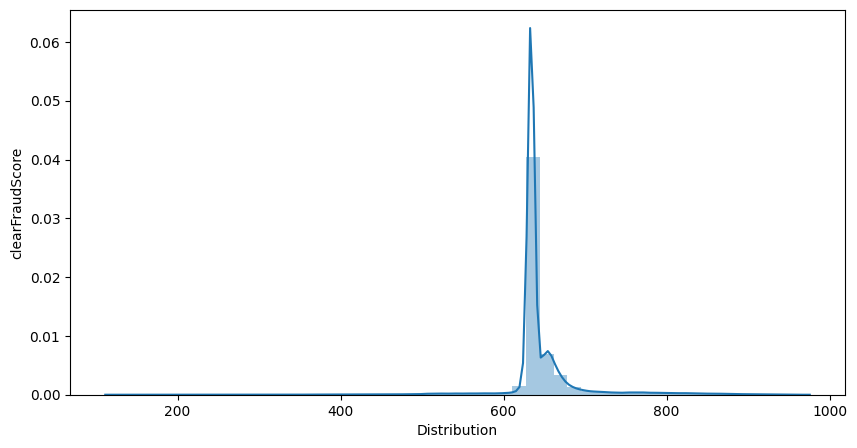

In [69]:
# Visualize Data Distribution
plt.figure(figsize=(10,5))
plt.xlabel('Distribution')
plt.ylabel('clearFraudScore')
sns.distplot(dfLUPNumerical[targetVariable],kde=True)
plt.show()

# Model Development

### Random Forest

In [70]:
"""
Basic RF Model - tanh
"""
forest1 = RandomForestRegressor(n_estimators = 500, random_state = 42,verbose = True)
forest1.fit(X_trainNorm,y_train)
forest_pred1 = forest1.predict(X_testNorm)
mean_squared_error(forest_pred1,y_test,squared = False), mean_absolute_error(forest_pred1,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 15.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.6s finished


(0.33107806315690574, 0.0025537922361448494)

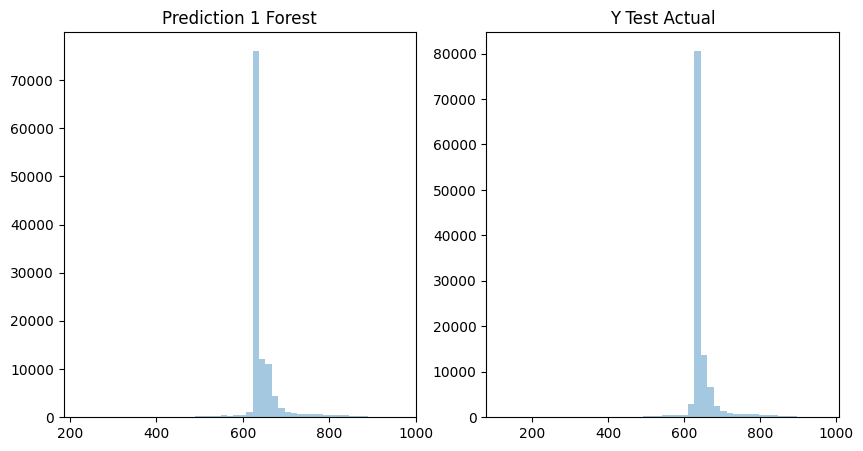

In [71]:
# Visualize Predicted Data Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Prediction 1 Forest")
sns.distplot(forest_pred1,kde=False,hist = True)
plt.subplot(1,2,2)
plt.title("Y Test Actual")
sns.distplot(y_test,kde=False,hist = True)
plt.show()

In [72]:
# """
# Running GridSearchCV to find best RF params. 
# """
# param_grid = {
#     "n_estimators": [500,800,1000],
#     "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
#     "max_features":["sqrt", "log2",1.0],
#     "warm_start" : [True,False]
# }
# # Run grid search
# gridModelForest = GridSearchCV(estimator=forest1,param_grid=param_grid,cv=10,verbose=3,scoring="f1")
# gridModelForest.fit(X_trainNorm,y_train)
# # Output values. 
# gridModelForest.best_params_

In [73]:
"""
Basic RF Model - ReLu
"""
forest2 = RandomForestRegressor(n_estimators = 500, random_state = 42,verbose = True)
forest2.fit(X_trainNormReLu,y_trainReLu)
forest_pred2 = forest2.predict(X_testNormReLu)
mean_squared_error(forest_pred2,y_testReLu,squared = False), mean_absolute_error(forest_pred2,y_testReLu)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 14.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.3s finished


(0.33032663798575396, 0.002497104430547466)

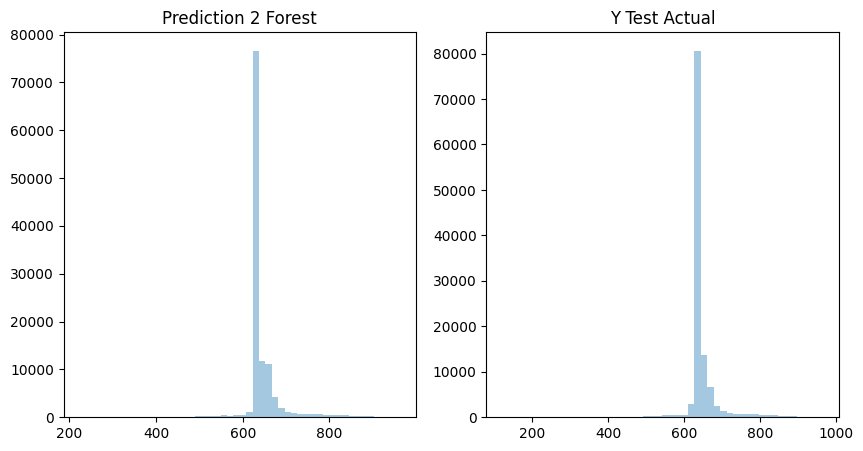

In [74]:
# Visualize Predicted Data Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Prediction 2 Forest")
sns.distplot(forest_pred2,kde=False,hist = True)
plt.subplot(1,2,2)
plt.title("Y Test Actual")
sns.distplot(y_test,kde=False,hist = True)
plt.show()

### Linear Regression - BEST PERFORMING

In [79]:
"""
# Basic RF Model - tanh
"""
linearReg1 = LinearRegression()
linearReg1.fit(X_trainNorm,y_train)
linReg_pred1 = linearReg1.predict(X_testNorm)
mean_squared_error(linReg_pred1,y_test,squared = False), mean_absolute_error(linReg_pred1,y_test)

(9.740949383133139e-14, 6.387209683997527e-14)

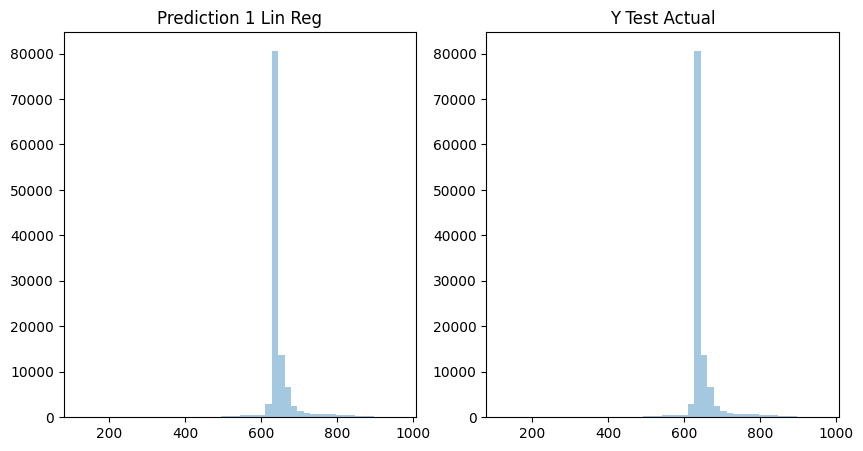

In [80]:
# Visualize Predicted Data Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Prediction 1 Lin Reg")
sns.distplot(linReg_pred1,kde=False,hist = True)
plt.subplot(1,2,2)
plt.title("Y Test Actual")
sns.distplot(y_test,kde=False,hist = True)
plt.show()

In [81]:
"""
# Basic RF Model - ReLu
"""
linearReg2 = LinearRegression()
linearReg2.fit(X_trainNormReLu,y_train)
linReg_pred2 = linearReg2.predict(X_testNormReLu)
mean_squared_error(linReg_pred2,y_testReLu,squared = False), mean_absolute_error(linReg_pred2,y_testReLu)

(8.807638861897891e-14, 5.689952115155331e-14)

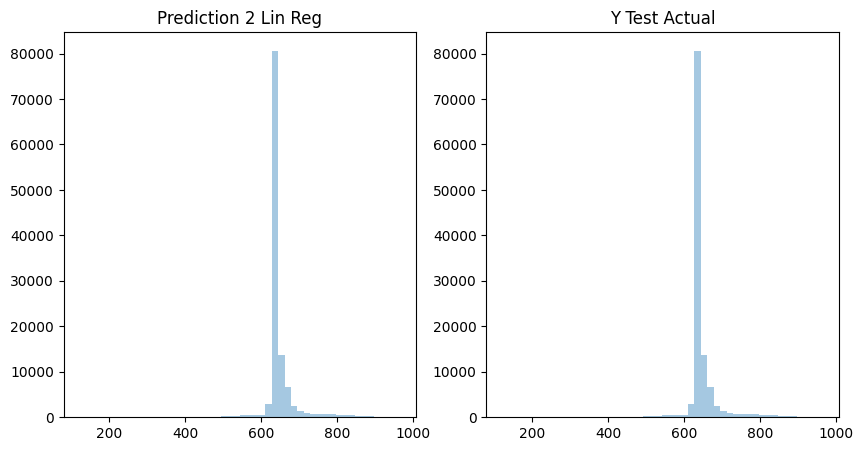

In [82]:
# Visualize Predicted Data Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Prediction 2 Lin Reg")
sns.distplot(linReg_pred2,kde=False,hist = True)
plt.subplot(1,2,2)
plt.title("Y Test Actual")
sns.distplot(y_test,kde=False,hist = True)
plt.show()

### SVM - SVR

In [112]:
"""
# Basic SVR Model - tanh
"""
svmReg1_tanh = SVR()
svmReg1_tanh.fit(X_trainNorm,y_train)
SVR_pred1 = svmReg1_tanh.predict(X_testNorm)
mean_squared_error(SVR_pred1,y_test,squared = False), mean_absolute_error(SVR_pred1,y_test)

(2.042802805278681, 0.45207148937170305)

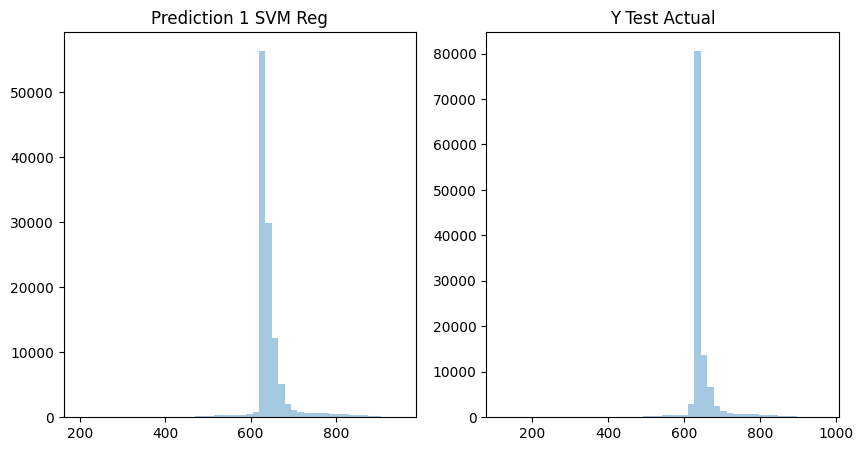

In [113]:
# Visualize Predicted Data Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Prediction 1 SVM Reg")
sns.distplot(SVR_pred1,kde=False,hist = True)
plt.subplot(1,2,2)
plt.title("Y Test Actual")
sns.distplot(y_test,kde=False,hist = True)
plt.show()

In [117]:
"""
# Basic SVR Model - ReLu
"""
svmReg2 = SVR()
svmReg2.fit(X_trainNormReLu,y_trainReLu)
SVR_pred2 = svmReg2.predict(X_testNormReLu)
mean_squared_error(SVR_pred2,y_testReLu,squared = False), mean_absolute_error(SVR_pred2,y_testReLu)

(3.635222813947108, 0.7553650504901116)

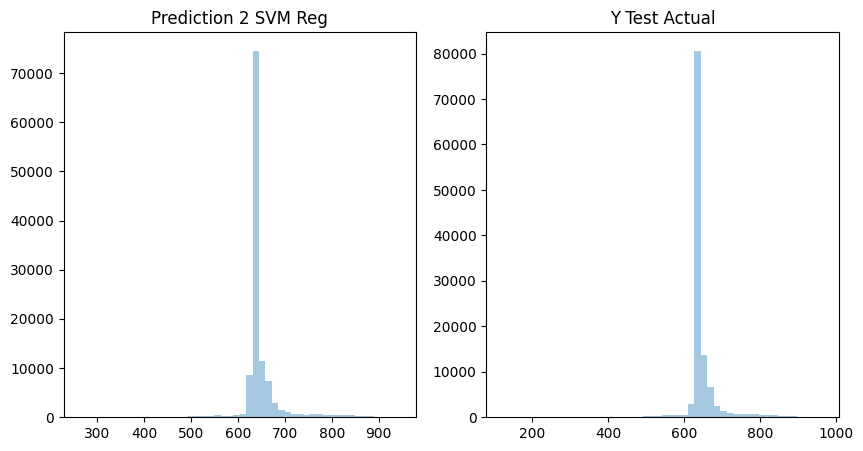

In [118]:
# Visualize Predicted Data Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Prediction 2 SVM Reg")
sns.distplot(SVR_pred2,kde=False,hist = True)
plt.subplot(1,2,2)
plt.title("Y Test Actual")
sns.distplot(y_testReLu,kde=False,hist = True)
plt.show()

### Neural Network

In [121]:
inputs = Input(shape = (X_train.shape[1],))
x = Dense(66,activation = "relu")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(33,activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(22,activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(22,activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Flatten()(x)
x = Dense(11,activation = "relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = Dense(1,activation = "tanh")(x)
NNReg1 = tf.keras.Model(inputs,outputs = [outputs,],name="NNReg1")
# Compile model
NNReg1.compile(loss="mae",
                optimizer="SGD",
                metrics="mae")
NNReg1.summary()
history_NNReg1 = NNReg1.fit(X_trainNorm, y_train, epochs=50, verbose=1,batch_size=64)
NN_Pred1 = NNReg1.predict(X_testNorm)
mean_squared_error(NN_Pred1,y_test,squared = False), mean_absolute_error(NN_Pred1,y_test)

Model: "NNReg1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_24 (Dense)            (None, 66)                1518      
                                                                 
 batch_normalization_13 (Bat  (None, 66)               264       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 33)                2211      
                                                                 
 batch_normalization_14 (Bat  (None, 33)               132       
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 22)                748  

(645.8824397949558, 644.2011505983332)

# CONCLUSION

Based on Analysis the best performing model is the Linear Regression Model on the ReLu based embedding

Final Results: 

RMSE: 9.565768490618245e-14 

MSE: 6.266529563304209e-14

Require additonal test data to validate performance of model in production


--------------------------------------------------------------------------------------------------------------- THE END ------------------------------------------------------------------------------------------------------------------------